In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [213]:
path = "D:\\Bootcamp\\MIMIC IV\\"
admissions = pd.read_csv(path + "core\\admissions.csv.gz", compression='gzip')
patients = pd.read_csv(path + "core\\patients.csv.gz", compression='gzip')
# transfers = pd.read_csv(path + "core\\transfers.csv.gz", compression='gzip')

diagnoses = pd.read_csv(path + "hosp\\diagnoses_icd.csv.gz", compression='gzip')
d_diagnoses = pd.read_csv(path + "hosp\\d_icd_diagnoses.csv.gz", compression='gzip')
drg_codes = pd.read_csv(path + "hosp\\drgcodes.csv.gz", compression='gzip')

d_lab_events = pd.read_csv(path + "hosp\\d_labitems.csv.gz", compression='gzip')

In [214]:
# basic cleanup
admissions.admittime = pd.to_datetime(admissions.admittime)
admissions.dischtime = pd.to_datetime(admissions.dischtime)
admissions.ethnicity = admissions.ethnicity.str.lower()

diagnoses.icd_code = diagnoses.icd_code.str.strip()

d_diagnoses.icd_code = d_diagnoses.icd_code.str.strip()
d_diagnoses.long_title = d_diagnoses.long_title.str.lower()

drg_codes = drg_codes.drop_duplicates().groupby('hadm_id').first().reset_index()
drg_codes.description = drg_codes.description.str.lower()

In [14]:
# # optional options
# pd.set_option('max_rows', 40) 
# pd.set_option('min_rows', 40)        # display at least 100 rows when max is exceeded

# Generate Sample List

In [216]:
# basic feature engineering for identifying positive cases
pos_codes = d_diagnoses[(d_diagnoses['long_title'].str.contains('heart failure'))]
pos_codes = pos_codes[~pos_codes.long_title.str.contains('without')]
pos_diagnoses = diagnoses[diagnoses['icd_code'].isin(pos_codes.icd_code)]
admissions['pos_subj'] = np.where(admissions.subject_id.isin(pos_diagnoses.subject_id), 1, 0)
admissions['pos_adm'] = np.where(admissions.hadm_id.isin(pos_diagnoses.hadm_id), 1, 0)

# filter out children (ages masked as "0")
admissions = admissions.merge(patients[['subject_id', 'gender', 'anchor_age']], how='left', on=['subject_id'])
admissions = admissions.rename(columns={'anchor_age':'age'})
admissions = admissions[admissions.age > 0]
admissions = admissions.reset_index(drop=True)

In [217]:
admissions.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag,pos_subj,pos_adm,gender,age
0,12427812,21593330,2184-01-06 11:51:00,2184-01-10 11:45:00,NaN,URGENT,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,NaN,unknown,NaN,NaN,0,0,0,F,35
1,14029832,22059088,2120-01-18 01:28:00,2120-01-20 16:13:00,NaN,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,NaN,other,NaN,NaN,0,0,0,F,55
2,13676048,23865469,2193-01-19 05:27:00,2193-01-24 18:59:00,NaN,URGENT,PHYSICIAN REFERRAL,HOME,Other,?,MARRIED,white,NaN,NaN,0,0,0,F,33
3,13831972,27763544,2131-01-27 04:03:00,2131-01-27 05:39:00,NaN,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicaid,ENGLISH,SINGLE,white,2131-01-26 22:19:00,2131-01-27 05:39:00,0,0,0,F,46
4,18523038,25414328,2142-08-26 17:14:00,2142-08-27 10:00:00,NaN,DIRECT OBSERVATION,PROCEDURE SITE,NaN,Other,ENGLISH,SINGLE,white,NaN,NaN,0,0,0,F,63


In [227]:
admissions.groupby(['subject_id']).first()[['gender', 'pos_subj']].groupby('gender').pos_subj.value_counts()
# admissions[admissions.gender=='M'].groupby('subject_id').first()['pos_subj'].mean()
admissions.groupby('subject_id').first()['pos_subj'].mean()

0.11510377708915315

In [39]:
# # Refactoring in progress...

# # identify first admission for all patients
# first_idx = admissions[admissions.pos_subj==1].groupby('subject_id').admittime.idxmin()
# first_adm = admissions.iloc[first_idx].hadm_id.values
# admissions['first_adm'] = np.where(admissions.hadm_id.isin(first_adm), 1, 0)

# # identify target positive subjects
# pos_subj = admissions[(admissions.pos_subj == 1) &\
#                       (admissions.pos_adm == 0) & \
#                       (admissions.first_adm == 1)].subject_id.values

# # identify admission right before CHF for target positive subjects
# target_positives = admissions[admissions.subject_id.isin(pos_subj)]
# target_positives = target_positives.sort_values(['subject_id', 'admittime']).reset_index(drop=True)
# pos_prior_idx = target_positives[(target_positives.pos_adm==1)].groupby('subject_id').admittime.idxmin() - 1
# # DATE TIME FILTER
# pos_hadm_list = target_positives.iloc[pos_prior_idx].hadm_id.values

# # identify target negative subects
# ####

# # generate sample
# admissions['neg_samp'] = np.where(admissions.hadm_id.isin(neg_hadm_list), 1, 0)
# admissions['pos_samp'] = np.where(admissions.hadm_id.isin(pos_hadm_list), 1, 0)
# sample_admissions = admissions[(admissions.neg_samp==1) | (admissions.pos_samp==1)]

array([25679292, 23745275, 22798184, ..., 21942461, 23069082, 27144120],
      dtype=int64)

In [50]:
# pre_admissions
# neg_admissions
from sklearn.utils import resample
sample_admissions = pd.concat([pre_admissions, neg_admissions])
n = 10000
# sample_hadm = sample_admissions[['hadm_id', 'pos_subj']].drop_duplicates()
sample_hadm = resample(sample_admissions[['hadm_id', 'pos_subj']], \
                       n_samples = n, replace = False, \
                       stratify = sample_admissions.pos_subj, random_state = 0)
sample_hadm.pos_subj.mean()

0.0145

In [72]:
# create dataframes for first positive visits and most recent previous visits
first_adm = admissions.iloc[admissions[admissions.pos_subj==1].groupby('subject_id').admittime.idxmin()]
subj_list = first_adm[first_adm.pos_adm==0].subject_id.unique()

# create refernce dataframe
subj_admissions = admissions[admissions.subject_id.isin(subj_list)] # first admission is negative
subj_admissions = subj_admissions.sort_values(['subject_id', 'admittime']).reset_index(drop=True)
pos_admissions = subj_admissions[['subject_id', 'hadm_id', 'admittime', 'pos_adm']]
pos_admissions = pos_admissions.loc[pos_admissions[pos_admissions.pos_adm==1].groupby('subject_id').admittime.idxmin()]
pos_admissions = pos_admissions.rename(columns={'pos_adm':'first_pos'}).drop('admittime', axis=1)
subj_admissions = subj_admissions.merge(pos_admissions, how='left')

# slice based on first visit/prior visit
first_idx = subj_admissions[subj_admissions.first_pos==1].index
pos_admissions = subj_admissions.iloc[first_idx].reset_index(drop=True)
pre_admissions = subj_admissions.iloc[first_idx-1].reset_index(drop=True)
pre_admissions['time_delta'] = pos_admissions.admittime - pre_admissions.dischtime
pre_admissions = pre_admissions[pre_admissions.time_delta < pd.to_timedelta('365 days')].reset_index(drop=True)
pos_admissions = pos_admissions[pos_admissions.subject_id.isin(pre_admissions.subject_id)].reset_index(drop=True)

# pre_hadm = pre_admissions.hadm_id.values
# pos_hadm = pos_admissions.hadm_id.values

# filter negative patients
neg_admissions = admissions[(admissions.pos_subj==0) & (admissions.admittime < pd.to_datetime('2209'))]
neg_samp = np.random.choice(neg_admissions.hadm_id.values, neg_admissions.shape[0]//10, replace=False )
neg_admissions = neg_admissions[neg_admissions.hadm_id.isin(neg_samp)]

# sample patients
from sklearn.utils import resample
sample_admissions = pd.concat([pre_admissions, neg_admissions])
n = 10000
# sample_hadm = sample_admissions[['hadm_id', 'pos_subj']].drop_duplicates()
sample_admissions = resample(sample_admissions[['hadm_id', 'pos_subj']], \
                       n_samples = n, replace = False, \
                       stratify = sample_admissions.pos_subj, random_state = 0)
sample_hadm = sample_admissions.hadm_id.values

#sanity checks
print('Positive cases in sample: ', sample_admissions.pos_subj.sum())
# print('Mismatched patient count: ', np.sum(pos_admissions['subject_id'] - pre_admissions['subject_id']))
print('Positive case fraction:  ', sample_admissions.pos_subj.mean())
print('Are there any duplicate visits?')
print(sample_admissions[sample_admissions.pos_subj==1].hadm_id.unique()\
      in sample_admissions[sample_admissions.pos_subj==0].hadm_id.unique())

# sample_hadm = np.concatenate((pre_hadm, neg_hadm))

Positive cases in sample:  1279
Positive case fraction:   0.1279
Are there any duplicate visits?
False


D:\Software\anaconda3\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


# Create Sample Admissions Table

In [73]:
s_cols = ['pos_subj', 'hadm_id', 'subject_id', 'age', 'gender', 'ethnicity',\
          ]
s_admissions = admissions[admissions.hadm_id.isin(sample_hadm)][s_cols]
s_admissions.head()

,pos_subj,hadm_id,subject_id,age,gender,ethnicity
82,0,26993393,12956420,29,F,white
138,0,25714218,16047924,37,M,white
237,0,28065085,17724165,50,F,white
246,0,20765830,14359524,70,M,white
294,0,20973444,18560897,54,M,unknown
...,...,...,...,...,...,...
462751,0,28281843,17516272,37,M,white
462778,0,28754900,17583402,78,M,white
462796,0,28145020,12482183,66,F,other
462839,0,29580198,12861229,38,F,white


In [74]:
# feature cleaning
s_admissions.loc[s_admissions.ethnicity=='unable to obtain', 'ethnicity'] = 'unknown'


In [76]:
s_drg = drg_codes[drg_codes.hadm_id.isin(sample_hadm)][['hadm_id', 'description']]
comorbidities =  ['sepsis', 'pneumoia', 'diabetes', 'hypertension',\
              'renal failure', 'kidney failure',\
              'atrial fibrillation', 'atherosclero', 'cardiac arrhythmia']
# come back for "vascular procedures", "coronary bypass", "cardiac congenital"
for comorb in comorbidities:
    s_drg[comorb] =  np.where(s_drg.description.str.contains(comorb), 1, 0)
s_drg.head()

,hadm_id,description,sepsis,pneumoia,diabetes,hypertension,renal failure,kidney failure,atrial fibrillation,atherosclero,cardiac arrhythmia
47,20001770,cirrhosis & alcoholic hepatitis w mcc,0,0,0,0,0,0,0,0,0
56,20002018,disorders of pancreas except malignancy w mcc,0,0,0,0,0,0,0,0,0
155,20005721,"malfunction, reaction & comp of cardiac or vas...",0,0,0,0,0,0,0,0,0
215,20007291,seizure,0,0,0,0,0,0,0,0,0
224,20007567,pulmonary edema & respiratory failure,0,0,0,0,0,0,0,0,0


In [77]:
s_icd = diagnoses[diagnoses.hadm_id.isin(sample_hadm)][['hadm_id', 'icd_version', 'icd_code']]
s_icd = s_icd.merge(d_diagnoses, how='left', on=['icd_version', 'icd_code'])
s_icd = s_icd.drop(['icd_code', 'icd_version'], axis=1)
s_icd = s_icd.groupby('hadm_id').agg(description=('long_title', lambda x: ''.join(str(x).rstrip()))).reset_index()
for comorb in comorbidities:
    s_icd[comorb] =  np.where(s_icd.description.str.contains(comorb), 1, 0)
s_icd.head()

,hadm_id,description,sepsis,pneumoia,diabetes,hypertension,renal failure,kidney failure,atrial fibrillation,atherosclero,cardiac arrhythmia
0,20001770,82670 ...,0,0,0,0,0,1,0,0,0
1,20002018,35966 dyspepsia and other specified disorde...,0,0,0,0,0,0,1,0,0
2,20005721,"1877 migraine, unspecified, without mention...",0,0,0,0,0,0,0,0,0
3,20007291,"9036 pressure ulcer,...",0,0,0,1,0,0,0,0,0
4,20007567,31094 amyotrophic later...,0,0,0,0,0,0,0,0,0


In [78]:
s_comorb = pd.merge(s_drg, s_icd, how='outer', on='hadm_id').fillna(0)
for co_ in comorbidities:
    s_comorb[co_] = s_comorb[co_+'_x'] + s_comorb[co_+'_y']
    s_comorb[co_] = np.where(s_comorb[co_] > 0, 1, 0)
    s_comorb = s_comorb.drop([co_+'_x', co_+'_y'], axis=1)
s_comorb['renal_failure'] = np.where((s_comorb['renal failure'] + s_comorb['kidney failure']) > 1, 1, 0)
s_comorb['arrhythmia'] = np.where((s_comorb['atrial fibrillation'] + s_comorb['cardiac arrhythmia']) > 1, 1, 0)
s_comorb = s_comorb.drop(['kidney failure', 'renal failure', 'atrial fibrillation', 'cardiac arrhythmia',\
                   'description_x', 'description_y'], axis=1)

In [79]:
s_admissions = s_admissions.merge(s_comorb, how='left', on='hadm_id').fillna(0)
s_admissions.to_pickle('s_admissions.pkl')

# Create Lab Events Table

In [ ]:
sample_items = [50861, 50868, 50882, 50885, 50902, 50912, 50960, \  # selected from EDA
             50970, 50971, 51006, 51221, 51222, 51237, 51248, \
             51249, 51250, 51265, 51274, 51275, 51277, 51279]

In [80]:
%%time
# load all tests in sample and save to file for reference

chunksize = 3*(10 ** 6)
chunk = 1
cols_ = ['subject_id', 'hadm_id', 'specimen_id', 'itemid', 'value', 'valuenum', 'valueuom', \
         'ref_range_lower', 'ref_range_upper', 'comments', 'flag']
lab_events = []
for lab_chunk in pd.read_csv(path + "hosp\\labevents.csv.gz", compression='gzip', chunksize=chunksize):
    lab_chunk = lab_chunk[lab_chunk.hadm_id.isin(sample_hadm)]
    lab_chunk = lab_chunk[lab_chunk.itemid.isin(sample_items)]
    lab_chunk = lab_chunk[cols_]
    lab_events.append(lab_chunk)
    print(f'Processed chunk: {chunk}')
    chunk += 1

lab_events = pd.concat(lab_events)
lab_events.to_pickle("lab_events.pkl")

Processed chunk: 1
Processed chunk: 2
Processed chunk: 3


<string>:2: DtypeWarning: Columns (7,9,12) have mixed types.Specify dtype option on import or set low_memory=False.


Processed chunk: 4
Processed chunk: 5
Processed chunk: 6
Processed chunk: 7
Processed chunk: 8
Processed chunk: 9


<string>:2: DtypeWarning: Columns (9,12) have mixed types.Specify dtype option on import or set low_memory=False.


Processed chunk: 10


<string>:2: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.


Processed chunk: 11
Processed chunk: 12
Processed chunk: 13
Processed chunk: 14
Processed chunk: 15


<string>:2: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.


Processed chunk: 16
Processed chunk: 17
Processed chunk: 18
Processed chunk: 19
Processed chunk: 20
Processed chunk: 21
Processed chunk: 22
Processed chunk: 23


<string>:2: DtypeWarning: Columns (7,9) have mixed types.Specify dtype option on import or set low_memory=False.


Processed chunk: 24
Processed chunk: 25
Processed chunk: 26
Processed chunk: 27
Processed chunk: 28
Processed chunk: 29
Processed chunk: 30
Processed chunk: 31
Processed chunk: 32
Processed chunk: 33
Processed chunk: 34
Processed chunk: 35
Processed chunk: 36
Processed chunk: 37
Processed chunk: 38
Processed chunk: 39
Processed chunk: 40
Processed chunk: 41
Wall time: 5min 27s


# %%%%%%%% Warm Start for Lab Data %%%%%%%%%%

In [178]:
path = "D:\\Bootcamp\\MIMIC IV\\"
d_lab_events = pd.read_csv(path + "hosp\\d_labitems.csv.gz", compression='gzip')
s_admissions = pd.read_pickle("s_admissions.pkl")
sample_hadm = s_admissions.hadm_id.values
print(s_admissions.shape)
s_admissions.head()

(10000, 13)


,pos_subj,hadm_id,subject_id,age,gender,ethnicity,sepsis,pneumoia,diabetes,hypertension,atherosclero,renal_failure,arrhythmia
0,0,26993393,12956420,29,F,white,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,25714218,16047924,37,M,white,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,28065085,17724165,50,F,white,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,20765830,14359524,70,M,white,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,20973444,18560897,54,M,unknown,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [179]:
lab_events = pd.read_pickle("lab_events.pkl")
print(lab_events.shape)
lab_events.head()

(686583, 11)


,subject_id,hadm_id,specimen_id,itemid,value,valuenum,valueuom,ref_range_lower,ref_range_upper,comments,flag
2296,12457431,26743064.0,3017232,50868,15,15.0,mEq/L,8.0,20.0,NaN,NaN
2297,12457431,26743064.0,3017232,50882,27,27.0,mEq/L,22.0,32.0,NaN,NaN
2298,12457431,26743064.0,3017232,50902,103,103.0,mEq/L,96.0,108.0,NaN,NaN
2299,12457431,26743064.0,3017232,50912,0.9,0.9,mg/dL,0.5,1.2,NaN,NaN
2300,12457431,26743064.0,3017232,50971,4.0,4.0,mEq/L,3.3,5.1,NaN,NaN


# Lab Events Data Wrangling

### Data Cleaning

In [180]:
%%time

# Can probably make a helper function combining some of the below mapping

# Other invalid value imputation
# For now set them all to normal/most common value
lab_events.loc[(lab_events['value'].isin([np.nan, 'ERROR', 'UNABLE TO REPORT'])), ['value', 'valuenum']] = 1.1
lab_events.loc[(lab_events['itemid'] == 51237) & (lab_events['value'].isin(['>21.8'])), ['value', 'valuenum']] = 22
lab_events.loc[(lab_events['itemid'] == 51237) & (lab_events['value'].isin(['>19.2'])), ['value', 'valuenum']] = 20

lab_events.loc[(lab_events['itemid'] == 51275) &  (lab_events['value'].isin(['>150', '>150.0'])), ['value', 'valuenum']] = 175

# Should we just delete these?
# For 5k patients there are 6 records here
lab_events.loc[(lab_events['itemid'] == 51274) &  (lab_events['value'].isin(['ERROR'])), ['value', 'valuenum']] = 11

# Should we just delete these?
# For 5k patients there are 1 records here
lab_events.loc[(lab_events['itemid'] == 51275) &  (lab_events['value'].isin(['UNABLE TO REPORT'])), ['value', 'valuenum']] = 31

# Clumsy..
lab_events.loc[(lab_events['itemid'] == 51275) &  (lab_events['value'].isin(['34..3'])), ['value', 'valuenum']] = 34.3
lab_events.loc[lab_events.value==':UNABLE TO REPORT', ['value', 'valuenum']] = 'NaN'
lab_events.loc[lab_events.value=='UNABLE', ['value', 'valuenum']] = 'NaN'
lab_events.loc[lab_events.value=='>13.1', ['value', 'valuenum']] = 13

# 51466
lab_events.loc[(lab_events['itemid'] == 51466) & (lab_events['value'].isin([np.nan])), ['value']] = lab_events['comments']
lab_events.loc[(lab_events['itemid'] == 51466) & (lab_events['value'].isin(['NEG.  ', 'NEG', ' '])), ['value', 'valuenum']] = 0
lab_events.loc[(lab_events['itemid'] == 51466) & (lab_events['value'].isin(['TR', 'TR.  ', 'TR*.  '])), ['value', 'valuenum']] = 1
lab_events.loc[(lab_events['itemid'] == 51466) & (lab_events['value'].isin(['SM', 'SM .  ', 'SM*.  '])), ['value', 'valuenum']] = 2
lab_events.loc[(lab_events['itemid'] == 51466) & (lab_events['value'].isin(['MOD', 'MOD.  ', 'MOD*.  '])), ['value', 'valuenum']] = 3
lab_events.loc[(lab_events['itemid'] == 51466) & (lab_events['value'].isin(['LG', 'LG.  ', 'LG*.  ', 'LGE', 'LRG'])), ['value', 'valuenum']] = 4

lab_events.loc[(lab_events['itemid'] == 51466) & (lab_events['ref_range_lower'].isnull()), 'ref_range_lower'] = 0
lab_events.loc[(lab_events['itemid'] == 51466) & (lab_events['ref_range_upper'].isnull()), 'ref_range_upper'] = 0

# 51514
lab_events.loc[(lab_events['itemid'] == 51514) & (lab_events['value'].isin([np.nan])), ['value']] = lab_events['comments']
lab_events.loc[(lab_events['itemid'] == 51514) & (lab_events['value'].isin(['NEG.  ', 'NEG', 'NORMAL.  ', ' '])), ['value', 'valuenum']] = 0
lab_events.loc[(lab_events['itemid'] == 51514) & (lab_events['value'].isin(['>8'])), ['value', 'valuenum']] = 10
lab_events.loc[(lab_events['itemid'] == 51514) & (lab_events['value'].isin(['>12.  ', '>12*.  '])), ['value', 'valuenum']] = 15

# 51464
lab_events.loc[(lab_events['itemid'] == 51464) & (lab_events['value'].isin([np.nan])), ['value']] = lab_events['comments']
lab_events.loc[(lab_events['itemid'] == 51464) & (lab_events['value'].isin(['NEG.  ', 'NEG', ' '])), ['value', 'valuenum']] = 0
lab_events.loc[(lab_events['itemid'] == 51464) & (lab_events['value'].isin(['SM', 'SM .  ', 'SM*.  '])), ['value', 'valuenum']] = 1
lab_events.loc[(lab_events['itemid'] == 51464) & (lab_events['value'].isin(['MOD', 'MOD.  ', 'MOD*.  '])), ['value', 'valuenum']] = 2
lab_events.loc[(lab_events['itemid'] == 51464) & (lab_events['value'].isin(['LG', 'LG.  ', 'LG*.  ', 'LGE'])), ['value', 'valuenum']] = 3

lab_events.loc[(lab_events['itemid'] == 51464) & (lab_events['ref_range_lower'].isnull()), 'ref_range_lower'] = 0
lab_events.loc[(lab_events['itemid'] == 51464) & (lab_events['ref_range_upper'].isnull()), 'ref_range_upper'] = 0

# 51487
# Should Pos be marked abnormal?
lab_events.loc[(lab_events['itemid'] == 51487) & (lab_events['value'].isin([np.nan])), ['value']] = lab_events['comments']
lab_events.loc[(lab_events['itemid'] == 51487) & (lab_events['value'].isin(['NEG.  ', 'NEG', ' '])), ['value', 'valuenum']] = 0
lab_events.loc[(lab_events['itemid'] == 51487) & (lab_events['value'].isin(['POS.  ', 'POS', 'POS*.  '])), ['value', 'valuenum']] = 1

lab_events.loc[(lab_events['itemid'] == 51487) & (lab_events['ref_range_lower'].isnull()), 'ref_range_lower'] = 0
lab_events.loc[(lab_events['itemid'] == 51487) & (lab_events['ref_range_upper'].isnull()), 'ref_range_upper'] = 0

# 51492
# Should Pos be marked abnormal?
lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['value'].isin([np.nan])), ['value']] = lab_events['comments']
lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['value'].isin(['___'])), ['value', 'valuenum']] = np.nan
lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['value'].isin(['NEG.  ', 'NEG', ' '])), ['value', 'valuenum']] = 0
lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['value'].isin(['TR', 'TR.  ', 'TR*.  '])), ['value', 'valuenum']] = 10
lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['value'].str.contains('TR.')), ['value', 'valuenum']] = 10
lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['value'].isin(['>300'])), ['value', 'valuenum']] = 350
lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['value'].isin(['>600.  ', '>600*.  '])), ['value', 'valuenum']] = 700

lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['ref_range_lower'].isnull()), 'ref_range_lower'] = 0
lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['ref_range_upper'].isnull()), 'ref_range_upper'] = 0

# 51486
lab_events.loc[(lab_events['itemid'] == 51486) & (lab_events['value'].isin([np.nan])), ['value']] = lab_events['comments']
lab_events.loc[(lab_events['itemid'] == 51486) & (lab_events['value'].isin(['NEG.  ', 'NEG', ' ', 'N'])), ['value', 'valuenum']] = 0
lab_events.loc[(lab_events['itemid'] == 51486) & (lab_events['value'].isin(['TR', 'TR.  ', 'TR*.  '])), ['value', 'valuenum']] = 1
lab_events.loc[(lab_events['itemid'] == 51486) & (lab_events['value'].isin(['SM', 'SM .  ', 'SM*.  '])), ['value', 'valuenum']] = 2
lab_events.loc[(lab_events['itemid'] == 51486) & (lab_events['value'].isin(['MOD', 'MOD.  ', 'MOD*.  '])), ['value', 'valuenum']] = 3
lab_events.loc[(lab_events['itemid'] == 51486) & (lab_events['value'].isin(['LG', 'LG.  ', 'LG*.  ', 'LGE'])), ['value', 'valuenum']] = 4

lab_events.loc[(lab_events['itemid'] == 51486) & (lab_events['ref_range_lower'].isnull()), 'ref_range_lower'] = 0
lab_events.loc[(lab_events['itemid'] == 51486) & (lab_events['ref_range_upper'].isnull()), 'ref_range_upper'] = 0

# 51506
lab_events.loc[(lab_events['itemid'] == 51506) & (lab_events['value'].isin([np.nan])), ['value']] = lab_events['comments']
lab_events.loc[(lab_events['itemid'] == 51506) & (lab_events['value'].isin(['Clear.  ', 'CLEAR.  ', 'Clear', ' ', 'CLEAR'])), ['value', 'valuenum']] = 0
lab_events.loc[(lab_events['itemid'] == 51506) & (lab_events['value'].isin(['SlHazy'])), ['value', 'valuenum']] = 0.5
lab_events.loc[(lab_events['itemid'] == 51506) & (lab_events['value'].isin(['Hazy.  ', 'Hazy*.  ', 'Hazy', 'HAZY', 'HAZY*.  ', 'Slcldy', 'SLCLOUDY'])), ['value', 'valuenum']] = 1
lab_events.loc[(lab_events['itemid'] == 51506) & (lab_events['value'].isin(['Cloudy*.  ', 'Cloudy.  ', 'Cloudy', 'CLO', 'CLOUDY', 'CLOU', 'CLOUDY*.  '])), ['value', 'valuenum']] = 2

lab_events.loc[(lab_events['itemid'] == 51506) & (lab_events['ref_range_lower'].isnull()), 'ref_range_lower'] = 0
lab_events.loc[(lab_events['itemid'] == 51506) & (lab_events['ref_range_upper'].isnull()), 'ref_range_upper'] = 0

lab_events.valuenum = lab_events.valuenum.astype(float)

Wall time: 3.95 s


In [181]:
# sanity check

lab_events.loc[((lab_events['value'].astype(str) + str('.0')) != lab_events['valuenum'].astype(str)) 
                           & ((lab_events['value'].astype(str) + str('0')) != lab_events['valuenum'].astype(str)) 
                           & ((lab_events['value'].astype(str)) != lab_events['valuenum'].astype(str)) 
                           & ((lab_events['value'].astype(str)) != lab_events['valuenum'].astype(str) + str('0')) 
                           & ((str('0') + lab_events['value'].astype(str)) != lab_events['valuenum'].astype(str))
                           & ((lab_events['value'].astype(str)) != round(lab_events['valuenum'].astype(float), 10).astype(str))
                           ]


,subject_id,hadm_id,specimen_id,itemid,value,valuenum,valueuom,ref_range_lower,ref_range_upper,comments,flag
29802095,12579086,28532480.0,17907229,51275,NaN,NaN,sec,25.0,36.5,NaN,abnormal


### Transform Into Aggregates (min, max, mean, etc.)

In [182]:
%%time

sample_labs = lab_events.groupby(['subject_id', 'hadm_id', 'itemid'])
sample_labs = sample_labs.agg({'itemid' : ['count'],
                               'valuenum' : ['min', 'max', 'mean'],
                               'flag' : ['count'],
                               'ref_range_lower' : ['min'],
                               'ref_range_upper' : ['min']
                              })
sample_labs.reset_index(inplace = True)
sample_labs.columns = ['subject_id', 'hadm_id', 'itemid', 'count', 'min', 'max', 'mean', 'abn_percent', 'range_min', 'range_max']
sample_labs['below_min'] = np.where(sample_labs['min'] < sample_labs['range_min'], sample_labs['range_min'] - sample_labs['min'], 0)
sample_labs['above_max'] = np.where(sample_labs['max'] > sample_labs['range_max'], sample_labs['max'] - sample_labs['range_max'], 0)
sample_labs['abn_percent'] = sample_labs['abn_percent'] / sample_labs['count']
missing_vals = sample_labs.isnull().sum(axis = 0) 
missing_vals[missing_vals > 0].sort_values()


Wall time: 358 ms


Series([], dtype: int64)

In [183]:
sample_labs_pivot = sample_labs.pivot(index = 'hadm_id', columns = 'itemid', values = ['mean', 'below_min', 'above_max'])
sample_labs_pivot = sample_labs_pivot.reset_index()

missing_vals = sample_labs_pivot.isnull().sum(axis = 0) 
missing_vals[missing_vals > 0].groupby('itemid').mean().sort_values(ascending=False)


itemid
50885    4343
50861    4247
51275    3267
51274    3102
51237    3102
50970    1392
50960    1235
50868     671
50882     671
50902     617
50971     575
51006     558
50912     497
51279     378
51277     378
51248     378
51249     378
51250     378
51222     369
51265     315
51221     175
dtype: int64

In [184]:
# sample_labs_pivot = pd.read_pickle('sample_labs_pivot.pkl')

lab_names = d_lab_events.loc[d_lab_events['itemid'].isin(sample_items)].copy()
lab_names.label = lab_names.label.str.replace(' ','').str.replace(',','')

lab_names = lab_names[['itemid', 'label']]
lab_names.set_index('itemid', inplace = True)
d_lab_names = lab_names.to_dict()['label']

num_cols = ~sample_labs_pivot.columns.isin([('hadm_id', '')])
col_names = []
col_names = list(sample_labs_pivot.loc[:, num_cols].columns)
x, y = zip(*col_names)
col_names = list(zip(x, list(map(d_lab_names.get, y))))
rename_dict = dict(zip(sample_labs_pivot.loc[:, num_cols].columns, col_names))

sample_labs_pivot.columns = sample_labs_pivot.columns.to_flat_index()
sample_labs_pivot.rename(columns = rename_dict, inplace=True)
sample_labs_pivot.columns = [str(col_[0]) + ' ' + str(col_[1]) for col_ in sample_labs_pivot.columns]
sample_labs_pivot.columns = [str.strip(col_) for col_ in sample_labs_pivot.columns]
sample_labs_pivot.head()

,hadm_id,mean AlanineAminotransferase(ALT),mean AnionGap,mean Bicarbonate,mean BilirubinTotal,mean Chloride,mean Creatinine,mean Magnesium,mean Phosphate,mean Potassium,...,above_max Hemoglobin,above_max INR(PT),above_max MCH,above_max MCHC,above_max MCV,above_max PlateletCount,above_max PT,above_max PTT,above_max RDW,above_max RedBloodCells
0,20001770.0,36.466667,11.421053,17.947368,16.226667,103.421053,1.173684,2.221053,2.784211,4.015789,...,0.0,1.4,4.5,0.0,14.0,0.0,15.1,13.3,14.9,0.0
1,20002018.0,23.000000,13.000000,28.833333,0.300000,100.500000,0.633333,1.720000,3.820000,3.916667,...,0.0,0.4,0.0,0.0,0.0,0.0,3.4,NaN,0.2,0.0
2,20005721.0,20.000000,11.400000,21.200000,0.400000,106.600000,0.340000,1.500000,2.300000,3.583333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20006517.0,6.000000,13.666667,23.000000,0.200000,112.666667,1.766667,2.266667,3.933333,3.566667,...,0.0,4.3,0.0,0.0,0.0,0.0,34.7,5.1,0.0,0.0
4,20007291.0,27.000000,14.000000,24.250000,1.900000,106.750000,0.950000,2.000000,2.575000,3.825000,...,0.0,NaN,0.1,0.4,0.0,0.0,NaN,NaN,0.0,0.0


### KNN Imputation

In [185]:
s_impute_prep = sample_labs_pivot.copy()
s_impute_prep = s_impute_prep.merge(s_admissions, how='left', on='hadm_id')
s_impute_prep.hadm_id = s_impute_prep.hadm_id.astype(int)

dummy = pd.get_dummies(s_impute_prep['ethnicity'], prefix='ethnicity')
dummy.drop('ethnicity_white', axis=1, inplace=True)
s_impute_prep = s_impute_prep.drop('ethnicity', axis=1)
s_impute_prep = pd.concat([s_impute_prep, dummy], axis=1)

s_impute_prep['gender'] = s_impute_prep['gender'].map({'M' : 0.0, 'F' : 1.0})
s_impute_prep['gender'] = pd.to_numeric(s_impute_prep['gender'])

s_impute_prep.head()

,hadm_id,mean AlanineAminotransferase(ALT),mean AnionGap,mean Bicarbonate,mean BilirubinTotal,mean Chloride,mean Creatinine,mean Magnesium,mean Phosphate,mean Potassium,...,hypertension,atherosclero,renal_failure,arrhythmia,ethnicity_american indian/alaska native,ethnicity_asian,ethnicity_black/african american,ethnicity_hispanic/latino,ethnicity_other,ethnicity_unknown
0,20001770,36.466667,11.421053,17.947368,16.226667,103.421053,1.173684,2.221053,2.784211,4.015789,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
1,20002018,23.000000,13.000000,28.833333,0.300000,100.500000,0.633333,1.720000,3.820000,3.916667,...,0.0,0.0,0.0,0.0,0,0,0,0,1,0
2,20005721,20.000000,11.400000,21.200000,0.400000,106.600000,0.340000,1.500000,2.300000,3.583333,...,0.0,0.0,0.0,0.0,0,0,0,1,0,0
3,20006517,6.000000,13.666667,23.000000,0.200000,112.666667,1.766667,2.266667,3.933333,3.566667,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
4,20007291,27.000000,14.000000,24.250000,1.900000,106.750000,0.950000,2.000000,2.575000,3.825000,...,1.0,0.0,0.0,0.0,0,0,0,0,0,1


In [186]:
%%time

from sklearn.impute import KNNImputer
import math
imputer = KNNImputer(n_neighbors=math.trunc((s_impute_prep.shape[0] ** 0.5)))
sample_labs_imputed = imputer.fit_transform(s_impute_prep)

Wall time: 21.6 s


In [187]:
sample_labs_imputed = pd.DataFrame(sample_labs_imputed)
sample_labs_imputed.columns = s_impute_prep.columns

In [188]:
print(sample_labs_imputed.hadm_id.isna().sum())
print(sample_labs_imputed.shape)

0
(7615, 81)


In [189]:
sample_labs_imputed.head()

,hadm_id,mean AlanineAminotransferase(ALT),mean AnionGap,mean Bicarbonate,mean BilirubinTotal,mean Chloride,mean Creatinine,mean Magnesium,mean Phosphate,mean Potassium,...,hypertension,atherosclero,renal_failure,arrhythmia,ethnicity_american indian/alaska native,ethnicity_asian,ethnicity_black/african american,ethnicity_hispanic/latino,ethnicity_other,ethnicity_unknown
0,20001770.0,36.466667,11.421053,17.947368,16.226667,103.421053,1.173684,2.221053,2.784211,4.015789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20002018.0,23.000000,13.000000,28.833333,0.300000,100.500000,0.633333,1.720000,3.820000,3.916667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,20005721.0,20.000000,11.400000,21.200000,0.400000,106.600000,0.340000,1.500000,2.300000,3.583333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,20006517.0,6.000000,13.666667,23.000000,0.200000,112.666667,1.766667,2.266667,3.933333,3.566667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20007291.0,27.000000,14.000000,24.250000,1.900000,106.750000,0.950000,2.000000,2.575000,3.825000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Machine Learning Models

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import validation_curve

sample_labs_imputed = pd.read_pickle("sample_labs_imputed.pkl")

In [192]:
sample_labs_imputed.shape

(7615, 81)

### Basic Test Train Split

In [193]:
hadm_features = sample_labs_imputed.drop(['hadm_id', 'pos_subj', 'subject_id'], axis=1)
hadm_target = sample_labs_imputed.pos_subj

X_train, X_test, y_train, y_test = train_test_split(hadm_features, hadm_target, test_size=.2,\
                                                    stratify=hadm_target, random_state=25)
#oversample
X_train_over, y_train_over = SMOTE().fit_resample(X_train, y_train)

#undersample
X_train_under, y_train_under = NearMiss().fit_resample(X_train, y_train)

### Standardization (optional)

In [194]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

hadm_features_std = sample_labs_imputed.drop(['hadm_id', 'pos_subj', 'subject_id'], axis=1)
scale_cols = ~hadm_features.columns.isin(['gender', 'sepsis', 'pneumoia', 'diabetes', 'hypertension', 'atherosclero', 'renal_failure', 'arrhythmia', 'ethnicity_american indian/alaska native', 'ethnicity_asian', 'ethnicity_black/african american', 'ethnicity_hispanic/latino', 'ethnicity_other', 'ethnicity_unknown'])
hadm_features_std.loc[:, scale_cols] = scaler.fit_transform(hadm_features.loc[:, scale_cols])

#standard
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(hadm_features_std, hadm_target, test_size=.2,\
                                                    stratify=hadm_target, random_state=25)
#oversample
X_train_over_s, y_train_over_s = SMOTE().fit_resample(X_train_s, y_train_s)

# Logistic Regression

### Base Model

Cross Validation
--------------------
Best parameter:  {'C': 1.3894954943731375}
Best CV score:  0.8250
Accuracy Score: 72.36%
_______________________________________________
Classification Report:	Precision Score: 31.27%
			Recall Score: 67.38%
			F1 score: 42.72%
			ROC_AUC score: 70.32%
_______________________________________________
Confusion Matrix: 
 [[945 345]
 [ 76 157]]



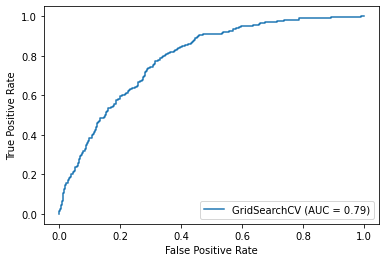

below_min Magnesium           1.963036
min Magnesium                 1.716859
arrhythmia                    1.641026
mean Magnesium                1.490133
min INR(PT)                   1.451340
ethnicity_unknown             1.153752
ethnicity_asian               1.065604
atherosclero                  1.034336
below_min Creatinine          1.010835
mean Creatinine               0.889401
above_max RedBloodCells       0.864396
diabetes                      0.831230
min RedBloodCells             0.798855
abn_percent BilirubinTotal    0.790758
below_min Potassium           0.665521
above_max Creatinine          0.628410
abn_percent AnionGap          0.591721
abn_percent Creatinine        0.477919
min Creatinine                0.473705
abn_percent Potassium         0.470722
above_max BilirubinTotal      0.459910
abn_percent UreaNitrogen      0.453024
mean Phosphate                0.436638
max Phosphate                 0.412045
abn_percent Bicarbonate       0.409966
dtype: float64


In [14]:
%%time

params ={'C':np.logspace(-3,1,15)}
logReg = LogisticRegression(penalty='l1', class_weight="balanced", solver='liblinear',\
                            tol = 0.001, max_iter=500, verbose=1)

grid_log = GridSearchCV(estimator=logReg, param_grid=params, cv=3, scoring='roc_auc', verbose=1, n_jobs=3)
grid_log.fit(X_train, y_train)
results(grid_log)

### Base Model (Oversampled)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed:  2.3min finished


[LibLinear]Cross Validation
--------------------
Best parameter:  {'C': 1.3894954943731375}
Best CV score:  0.8250
Accuracy Score: 72.23%
_______________________________________________
Classification Report:	Precision Score: 31.15%
			Recall Score: 67.38%
			F1 score: 42.61%
			ROC_AUC score: 70.24%
_______________________________________________
Confusion Matrix: 
 [[943 347]
 [ 76 157]]



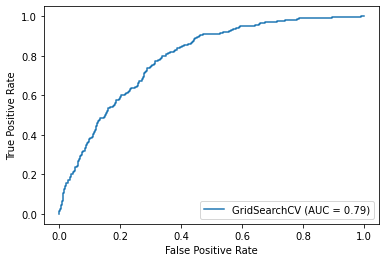

below_min Magnesium           1.952538
min Magnesium                 1.690897
arrhythmia                    1.641537
mean Magnesium                1.448425
min INR(PT)                   1.406969
ethnicity_unknown             1.153534
ethnicity_asian               1.064268
atherosclero                  1.033727
below_min Creatinine          1.020412
mean Creatinine               0.892235
above_max RedBloodCells       0.854805
diabetes                      0.830920
min RedBloodCells             0.803626
abn_percent BilirubinTotal    0.788420
below_min Potassium           0.661130
above_max Creatinine          0.626280
abn_percent AnionGap          0.590284
abn_percent Creatinine        0.477646
min Creatinine                0.475284
abn_percent Potassium         0.468555
above_max BilirubinTotal      0.459122
abn_percent UreaNitrogen      0.453011
mean Phosphate                0.436198
max Phosphate                 0.412498
abn_percent Bicarbonate       0.406933
dtype: float64
Wall time:

In [15]:
%%time

params ={'C':np.logspace(-3,1,15)}
logReg = LogisticRegression(penalty='l1', class_weight="balanced", solver='liblinear',\
                            tol = 0.001, max_iter=500, verbose=1)

grid_log_over = GridSearchCV(estimator=logReg, param_grid=params, cv=3, scoring='roc_auc', verbose=1, n_jobs=3)
grid_log_over.fit(X_train_over, y_train_over)
results(grid_log_over)

### Only Mean/BelowMin/AboveMax (Oversampled)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   31.4s
[Parallel(n_jobs=3)]: Done  90 out of  90 | elapsed:  1.4min finished


[LibLinear]Cross Validation
--------------------
Best parameter:  {'C': 0.727895384398315}
Best CV score:  0.8127
Accuracy Score: 72.49%
_______________________________________________
Classification Report:	Precision Score: 31.98%
			Recall Score: 70.82%
			F1 score: 44.06%
			ROC_AUC score: 71.80%
_______________________________________________
Confusion Matrix: 
 [[939 351]
 [ 68 165]]



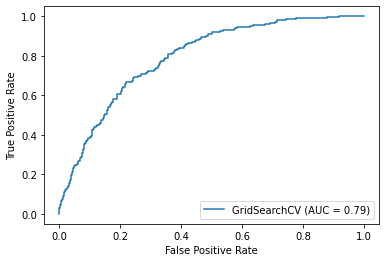

arrhythmia                          1.648112
ethnicity_unknown                   1.220406
ethnicity_asian                     1.107401
atherosclero                        1.059763
mean INR(PT)                        0.893110
diabetes                            0.751205
below_min RedBloodCells             0.638490
renal_failure                       0.568192
ethnicity_hispanic/latino           0.526881
mean Creatinine                     0.505207
above_max Creatinine                0.450523
below_min Creatinine                0.319582
above_max Magnesium                 0.302069
mean RDW                            0.293229
hypertension                        0.292500
above_max INR(PT)                   0.270834
above_max MCHC                      0.248770
above_max RDW                       0.234817
mean Potassium                      0.219194
above_max Phosphate                 0.180856
above_max Hematocrit                0.162252
mean Magnesium                      0.156562
ethnicity_

In [204]:
%%time

params ={'C':np.logspace(-2,1,30)}
logReg = LogisticRegression(penalty='l1', class_weight="balanced", solver='liblinear',\
                            tol = 0.001, max_iter=500, verbose=1)

grid_log_over = GridSearchCV(estimator=logReg, param_grid=params, cv=3, scoring='roc_auc', verbose=1, n_jobs=3)
grid_log_over.fit(X_train_over, y_train_over)
results(grid_log_over)

,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,0.100000,0.311741,0.601135,0.991416,0.330269,0.184948
1,0.188889,0.354839,0.667064,0.944206,0.474721,0.218471
2,0.277778,0.392229,0.708424,0.909871,0.568615,0.250000
3,0.366667,0.413939,0.719826,0.841202,0.635588,0.274510
4,0.455556,0.422604,0.710572,0.738197,0.691399,0.296041
5,0.544444,0.451149,0.718305,0.673820,0.749179,0.339093
6,0.633333,0.444062,0.691940,0.553648,0.787919,0.370690
7,0.722222,0.421053,0.659554,0.429185,0.819435,0.413223
8,0.811111,0.320442,0.596944,0.248927,0.838477,0.449612
9,0.900000,0.179211,0.545509,0.107296,0.849639,0.543478


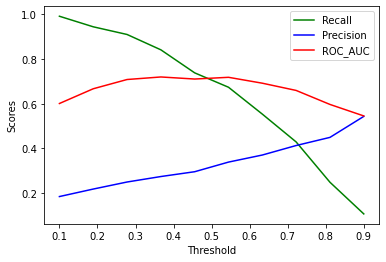

In [228]:
change_threshold(grid_log_over, np.linspace(0.1,.9,10), X_test)

### Only Mean/BelowMin/AboveMax (Oversampled + Standardized) (Not as Good)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  82 tasks      | elapsed:    9.0s
[Parallel(n_jobs=3)]: Done  90 out of  90 | elapsed:   10.3s finished


[LibLinear]Cross Validation
--------------------
Best parameter:  {'C': 1.1721022975334805}
Best CV score:  0.8163
Accuracy Score: 58.63%
_______________________________________________
Classification Report:	Precision Score: 22.77%
			Recall Score: 71.24%
			F1 score: 34.51%
			ROC_AUC score: 63.80%
_______________________________________________
Confusion Matrix: 
 [[727 563]
 [ 67 166]]



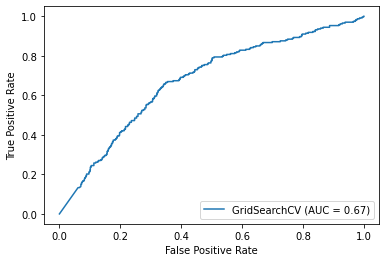

arrhythmia                                 1.642148
ethnicity_unknown                          1.312028
atherosclero                               1.025572
ethnicity_asian                            0.960268
age                                        0.768433
diabetes                                   0.712231
mean RDW                                   0.658354
above_max RDW                              0.656472
above_max Creatinine                       0.628308
mean AlanineAminotransferase(ALT)          0.530273
below_min Hematocrit                       0.495521
mean Creatinine                            0.480851
below_min RedBloodCells                    0.353990
mean INR(PT)                               0.339643
above_max BilirubinTotal                   0.338959
ethnicity_other                            0.324003
ethnicity_american indian/alaska native    0.323367
mean PT                                    0.312796
ethnicity_hispanic/latino                  0.306419
mean Bilirub

In [205]:
%%time

params ={'C':np.logspace(-2,1,30)}
logReg = LogisticRegression(penalty='l1', class_weight="balanced", solver='liblinear',\
                            tol = 0.001, max_iter=500, verbose=1)

grid_log_over_s = GridSearchCV(estimator=logReg, param_grid=params, cv=3, scoring='roc_auc', verbose=1, n_jobs=3)
grid_log_over_s.fit(X_train_over_s, y_train_over_s)
results(grid_log_over_s)

,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,0.010000,0.343925,0.641749,0.789700,0.539068,0.219833
1,0.108889,0.345168,0.640653,0.751073,0.564018,0.224072
2,0.207778,0.345382,0.640029,0.738197,0.571898,0.225426
3,0.306667,0.344478,0.638450,0.729614,0.575181,0.225464
4,0.405556,0.344615,0.638034,0.721030,0.580433,0.226415
5,0.504444,0.345833,0.638781,0.712446,0.587656,0.228336
6,0.603333,0.348008,0.641107,0.712446,0.591596,0.230236
7,0.702222,0.349308,0.641854,0.703863,0.598818,0.232295
8,0.801111,0.352052,0.644359,0.699571,0.606041,0.235209
9,0.900000,0.351111,0.641769,0.678112,0.616546,0.236882


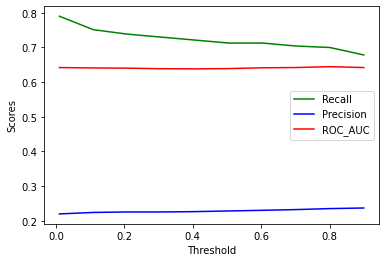

In [208]:
change_threshold(grid_log_over_s, np.linspace(0.01,.9,10), X_test_s)

# Random Forest

### Only Mean/BelowMin/AboveMax

Cross Validation
--------------------
Best parameter:  {'max_depth': 10.0, 'n_estimators': 1000}
Best CV score:  0.7855
Accuracy Score: 84.90%
_______________________________________________
Classification Report:	Precision Score: 100.00%
			Recall Score: 1.29%
			F1 score: 2.54%
			ROC_AUC score: 50.64%
_______________________________________________
Confusion Matrix: 
 [[1290    0]
 [ 230    3]]



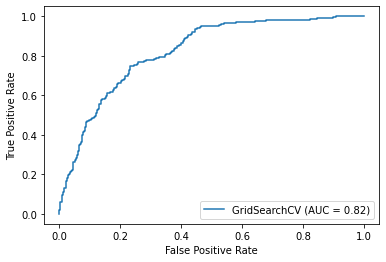

age                                  0.067883
mean UreaNitrogen                    0.061393
atherosclero                         0.037501
mean Creatinine                      0.036903
above_max UreaNitrogen               0.031677
mean RDW                             0.031014
mean Bicarbonate                     0.027445
mean MCHC                            0.025991
mean PT                              0.024288
mean Potassium                       0.023800
mean PTT                             0.022245
mean Phosphate                       0.021307
mean INR(PT)                         0.020834
mean Hemoglobin                      0.020629
mean PlateletCount                   0.020385
above_max PT                         0.020032
mean RedBloodCells                   0.019840
mean MCH                             0.019746
mean Chloride                        0.019465
mean Hematocrit                      0.019441
mean AlanineAminotransferase(ALT)    0.019333
mean Magnesium                    

In [65]:
%%time

from sklearn.ensemble import RandomForestClassifier

param_grid={'n_estimators': np.linspace(500,1000,4,dtype=int),
            'max_depth': np.linspace(5,20,4)
            }

rfc = RandomForestClassifier() 

grid_rf = GridSearchCV(estimator = rfc, param_grid = param_grid, cv=3,\
                                       scoring='roc_auc', verbose=1, n_jobs=3)
grid_rf.fit(X_train, y_train)
results(grid_rf)

### Only Mean/BelowMin/AboveMax (Oversampled)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  48 out of  48 | elapsed:  4.2min finished


Cross Validation
--------------------
Best parameter:  {'max_depth': 20.0, 'n_estimators': 666}
Best CV score:  0.9764
Accuracy Score: 84.44%
_______________________________________________
Classification Report:	Precision Score: 48.36%
			Recall Score: 25.32%
			F1 score: 33.24%
			ROC_AUC score: 60.22%
_______________________________________________
Confusion Matrix: 
 [[1227   63]
 [ 174   59]]



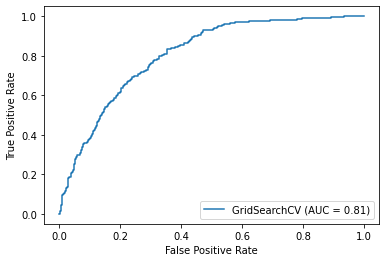

atherosclero                         0.079798
diabetes                             0.067258
age                                  0.060993
hypertension                         0.059873
above_max UreaNitrogen               0.047435
mean UreaNitrogen                    0.033920
mean RDW                             0.029048
above_max Creatinine                 0.027257
gender                               0.026564
mean Creatinine                      0.025120
above_max RDW                        0.022092
below_min Hemoglobin                 0.020347
mean MCHC                            0.016183
below_min Hematocrit                 0.014985
mean PlateletCount                   0.014866
below_min RedBloodCells              0.014551
mean Phosphate                       0.014203
mean PT                              0.013774
mean PTT                             0.013749
mean Chloride                        0.013749
mean Potassium                       0.013723
mean Bicarbonate                  

In [66]:
%%time

grid_rf_over = GridSearchCV(estimator = rfc, param_grid = param_grid, cv=3,\
                                       scoring='roc_auc', verbose=1, n_jobs=3)
grid_rf_over.fit(X_train_over, y_train_over)
results(grid_rf_over)

,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,0.100000,0.347095,0.658442,0.974249,0.439265,0.211163
1,0.105263,0.352758,0.666582,0.974249,0.453053,0.215370
2,0.110526,0.357762,0.673559,0.974249,0.464872,0.219112
3,0.115789,0.360159,0.676451,0.969957,0.472751,0.221135
4,0.121053,0.365105,0.683041,0.969957,0.483913,0.224876
5,0.126316,0.369281,0.688467,0.969957,0.493106,0.228052
6,0.131579,0.374482,0.695056,0.969957,0.504268,0.232033
7,0.136842,0.376569,0.697174,0.965665,0.510834,0.233888
8,0.142105,0.379427,0.700662,0.965665,0.516743,0.236097
9,0.147368,0.380629,0.701617,0.961373,0.521339,0.237288


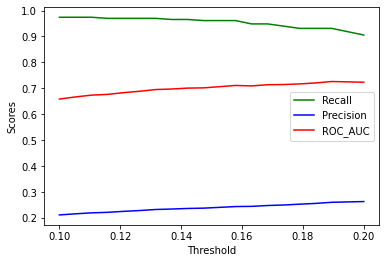

In [68]:
threshold_list = np.linspace(0.1,.2,20)
change_threshold(grid_rf_over, threshold_list, X_test)

# Gradient Boosting

### Only Mean/BelowMin/AboveMax (Oversampled)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  48 out of  48 | elapsed: 55.5min finished


Cross Validation
--------------------
Best parameter:  {'max_depth': 10.0, 'n_estimators': 833}
Best CV score:  0.9721
Accuracy Score: 84.24%
_______________________________________________
Classification Report:	Precision Score: 45.78%
			Recall Score: 16.31%
			F1 score: 24.05%
			ROC_AUC score: 56.41%
_______________________________________________
Confusion Matrix: 
 [[1245   45]
 [ 195   38]]



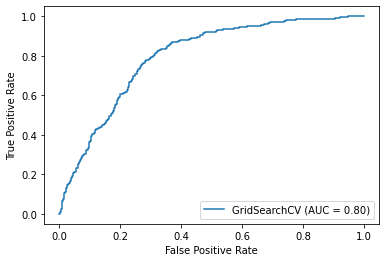

atherosclero                         0.243302
diabetes                             0.159436
age                                  0.069134
hypertension                         0.058248
above_max UreaNitrogen               0.032672
above_max RDW                        0.029372
mean PlateletCount                   0.020765
mean RDW                             0.020081
mean Creatinine                      0.018125
gender                               0.014818
mean UreaNitrogen                    0.013879
mean Bicarbonate                     0.013662
above_max Creatinine                 0.013002
mean MCHC                            0.012050
mean AlanineAminotransferase(ALT)    0.011434
mean Potassium                       0.011328
mean Phosphate                       0.011125
mean AnionGap                        0.011092
mean PTT                             0.010677
above_max PTT                        0.009828
mean Magnesium                       0.009036
mean Chloride                     

In [70]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid={'n_estimators': np.linspace(500,1000,4,dtype=int),
            'max_depth': np.linspace(5,20,4)
            }

gbc = GradientBoostingClassifier() 

grid_gb_over = GridSearchCV(estimator = gbc, param_grid = param_grid, cv=3,\
                                       scoring='roc_auc', verbose=1, n_jobs=3)
grid_gb_over.fit(X_train_over, y_train_over)
results(grid_gb_over)

,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,0.010000,0.352668,0.615803,0.326180,0.816809,0.383838
1,0.114444,0.300836,0.587973,0.231760,0.835194,0.428571
2,0.218889,0.277286,0.577990,0.201717,0.839133,0.443396
3,0.323333,0.256881,0.569974,0.180258,0.840446,0.446809
4,0.427778,0.250000,0.567620,0.171674,0.842416,0.459770
5,0.532222,0.241270,0.564491,0.163090,0.843073,0.463415
6,0.636667,0.227273,0.559603,0.150215,0.843729,0.466667
7,0.741111,0.225914,0.559783,0.145923,0.847012,0.500000
8,0.845556,0.183099,0.546104,0.111588,0.847669,0.509804
9,0.950000,0.139706,0.533021,0.081545,0.846356,0.487179


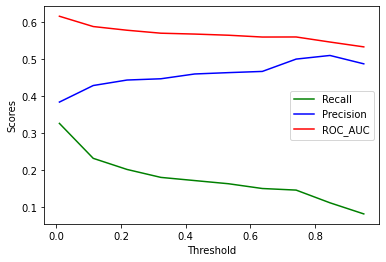

In [88]:
threshold_list = np.linspace(0.01,.95,10)
change_threshold(grid_gb_over, np.linspace(0.01,.95,10), X_test)

### Only Mean/BelowMin/AboveMax (Undersampled)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.5min finished


Cross Validation
--------------------
Best parameter:  {'max_depth': 10.0, 'n_estimators': 800}
Best CV score:  0.8969
Accuracy Score: 47.34%
_______________________________________________
Classification Report:	Precision Score: 20.52%
			Recall Score: 84.98%
			F1 score: 33.06%
			ROC_AUC score: 62.76%
_______________________________________________
Confusion Matrix: 
 [[523 767]
 [ 35 198]]



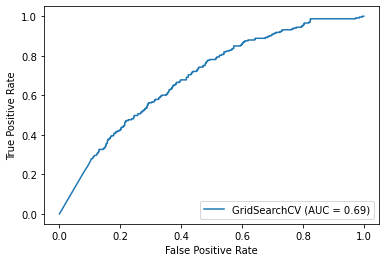

above_max UreaNitrogen                    0.155964
mean RDW                                  0.103111
above_max AlanineAminotransferase(ALT)    0.079166
mean PlateletCount                        0.063575
mean PTT                                  0.051183
mean UreaNitrogen                         0.044634
mean AlanineAminotransferase(ALT)         0.035511
atherosclero                              0.027977
above_max PTT                             0.027125
mean MCHC                                 0.025853
age                                       0.023179
mean MCV                                  0.022618
mean INR(PT)                              0.021897
mean MCH                                  0.019148
below_min PlateletCount                   0.019050
mean Hemoglobin                           0.017847
mean Phosphate                            0.017254
mean Bicarbonate                          0.016568
mean Hematocrit                           0.013171
below_min RedBloodCells        

In [83]:
param_grid={'n_estimators': np.linspace(800,1000,2,dtype=int),
            'max_depth': np.linspace(10,20,2)
            }

gbc = GradientBoostingClassifier(n_iter_no_change=1000) 

grid_gb_under = GridSearchCV(estimator = gbc, param_grid = param_grid, cv=3,\
                                       scoring='roc_auc', verbose=1, n_jobs=-1)
grid_gb_under.fit(X_train_under, y_train_under)
results(grid_gb_under)

,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,1.000000e-08,0.299601,0.578181,0.965665,0.309258,0.177305
1,2.000000e-08,0.298928,0.576990,0.957082,0.313198,0.177125
2,3.000000e-08,0.298588,0.576395,0.952790,0.315167,0.177033
3,4.000000e-08,0.299191,0.577558,0.952790,0.317137,0.177458
4,5.000000e-08,0.298447,0.576187,0.948498,0.317794,0.177083
5,6.000000e-08,0.298649,0.576575,0.948498,0.318450,0.177225
6,7.000000e-08,0.297498,0.574429,0.944206,0.317794,0.176565
7,8.000000e-08,0.298305,0.575979,0.944206,0.320420,0.177134
8,9.000000e-08,0.298507,0.576367,0.944206,0.321077,0.177276
9,1.000000e-07,0.298710,0.576754,0.944206,0.321733,0.177419


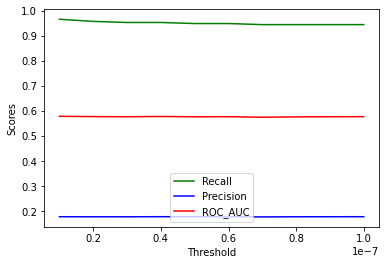

In [120]:
change_threshold(grid_gb_under, np.linspace(0.00000001,.0000001,10), X_test)

# Linear Discriminant Analysis

In [316]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

lda_cf = LinearDiscriminantAnalysis().fit(X_train, y_train)
# grid_lda = GridSearchCV(lda_cf, verbose=1)

qda_cf = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
# grid_qda = GridSearchCV(qda_cf, {'reg_param':[0,1]}, verbose=1)

D:\Software\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy Score: 73.55%
_______________________________________________
Classification Report:	Precision Score: 74.06%
			Recall Score: 79.77%
			F1 score: 76.81%
			ROC_AUC score: 72.88%
_______________________________________________
Confusion Matrix: 
 [[520 268]
 [194 765]]



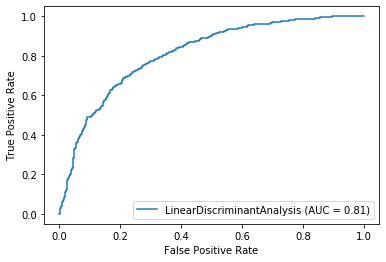

In [323]:
pred = lda_cf.predict(X_test)
print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
print("_______________________________________________")
print("Classification Report:", end='')
print(f"\tPrecision Score: {precision_score(y_test, pred) * 100:.2f}%")
print(f"\t\t\tRecall Score: {recall_score(y_test, pred) * 100:.2f}%")
print(f"\t\t\tF1 score: {f1_score(y_test, pred) * 100:.2f}%")
print(f"\t\t\tROC_AUC score: {roc_auc_score(y_test, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
svc_disp = plot_roc_curve(lda_cf, X_test, y_test)
plt.show()

In [318]:
qda_cf.score(X_test, y_test)

0.6393817973669147

# Comparing Models (Beta)

In [141]:
confusion_matrix(grid_log_over2.best_estimator_.predict(X_test_s),\
                grid_rf_over.best_estimator_.predict(X_test))

array([[992,   1],
       [409, 121]], dtype=int64)

In [142]:
confusion_matrix(grid_log_over2.best_estimator_.predict(X_test_s),\
                y_test_s)

array([[926,  67],
       [364, 166]], dtype=int64)

In [154]:
conf = pd.DataFrame({'truth':y_test, \
              'log':grid_log_over2.best_estimator_.predict(X_test_s), \
              'rf':grid_rf_over.best_estimator_.predict(X_test)})

In [159]:
conf.groupby('truth').agg({'log':'mean'})

,log
truth,
0.0,0.282171
1.0,0.712446


In [157]:
conf.groupby(['truth','log']).agg({'rf':'mean'})

rf
truth log          
0.0   0.0  0.001080
      1.0  0.170330
1.0   0.0  0.000000
      1.0  0.355422

# Helpful Functions from Brandon

In [64]:
import sklearn

def results(model):
    '''
    Function to report on the metrics of a GridSearch model.
    Input: GridSearchCV model
    Prints: CV score, best parameters, accuracy, precision, recall, F1, confusion matrix and ROCAUC
    '''
    
#     cross validation scores
    print("Cross Validation")
    print("-" * 20)
    print("Best parameter: ", model.best_params_)
    print("Best CV score:  %.4f" % model.best_score_)

#     confusion matrix & related scores
    pred = model.best_estimator_.predict(X_test)
    print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print("Classification Report:", end='')
    print(f"\tPrecision Score: {precision_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tRecall Score: {recall_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tF1 score: {f1_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tROC_AUC score: {roc_auc_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
    
    svc_disp = plot_roc_curve(model, X_test, y_test)
    plt.show()
    
    if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
        est_coefs = pd.Series(model.best_estimator_.coef_[0], index=X_train.columns)
        sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
        print(sortedCoefs[sortedCoefs > 0].head(25))
      
    else:
        est_coefs = pd.Series(model.best_estimator_.feature_importances_, index=X_train.columns)
        sortedCoefs = est_coefs.sort_values(ascending=False)
        print(sortedCoefs.head(25))
        
def change_threshold(model, threshold_list, X=X_test):
    '''
    Input a model and threshold_list.
    Output scores based on prediction made with threshold list.
    '''
    metrics = pd.DataFrame(columns = ['Threshold','F1','ROC_AUC','Recall','Accuracy','Precision'])
    
    for threshold in threshold_list:
        prob = model.best_estimator_.predict_proba(X_test)[:,1]
        pred = np.where(model.best_estimator_.predict_proba(X_test)[:,1]>threshold,1,0)


        f1 = f1_score(y_test, pred)
        roc_auc = roc_auc_score(y_test, pred)
        recall = recall_score(y_test, pred)
        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred)

        metrics = metrics.append({'Threshold':threshold,
                                  'F1':f1,
                                  'ROC_AUC':roc_auc,
                                  'Recall':recall,
                                  'Accuracy':accuracy,
                                  'Precision':precision}
                                 ,ignore_index=True)
        
    plt.plot(metrics.Threshold, metrics.Recall, label='Recall', color='green')
    plt.plot(metrics.Threshold, metrics.Precision, label='Precision', color='blue')
    plt.plot(metrics.Threshold, metrics.ROC_AUC, label='ROC_AUC', color='red')
    plt.legend()
    plt.xlabel('Threshold')
    plt.ylabel('Scores')
    return metrics

def plot_val_curve(estimator, feature, feature_range, X, y):
    '''
    Plots validation curve for an estimator and a feature for a specified feature range.
    Used to determine range of feature to use for hyperparameter tuning for GridSearchCV.
    '''
    train_scores, valid_scores = validation_curve(estimator, 
                                                  X,y,
                                                  feature,
                                                  feature_range, 
                                                  scoring='roc_auc',cv=3)
    plt.plot(feature_range,train_scores)
    plt.plot(feature_range,valid_scores,linestyle='--')
    plt.xlabel(feature)
    plt.ylabel('roc_auc')
    
def gather_best_features(model_list):
    best_features = pd.DataFrame()

    for model, model_name in model_list:
        if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
            est_coefs = pd.Series(model.best_estimator_.coef_[0], index=X_train.columns)
        else:
            est_coefs = pd.Series(model.best_estimator_.feature_importances_, index=X_train.columns)
            
        sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
        sorted_df = pd.DataFrame(sortedCoefs).reset_index().rename(columns={"index":'features', 0: model_name})
        best_features = pd.concat([best_features, sorted_df], axis=1)
    return best_features